[Оригинальный файл на Kaggle](https://www.kaggle.com/code/sharthz23/metrics-validation-strategies-and-baselines)

# Расчёт метрик

In [59]:
import os
from datetime import timedelta

from more_itertools import pairwise
import polars as pl
import seaborn as sns
from hydra import compose, initialize

In [60]:
sns.set_style("darkgrid")

In [61]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import model_cross_validate, precision_at_k, join_true_pred_and_preprocess, recall_at_k, mean_reciprocal_rank, mean_average_prec, compute_metrics
from recs_utils.load_data import MTSDataset, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge, BaseRecommender
from recs_utils.split import TimeRangeSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
with initialize(os.path.join("configs", "data"), version_base="1.3"):
    data_config = compose("mts_lib.yaml")

In [63]:
df = pl.read_parquet(data_config.dump_files.interactions_path)
df_users = pl.read_parquet(data_config.dump_files.users_path)
df_items = pl.read_parquet(data_config.dump_files.items_path)

In [64]:
df.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01


In [65]:
df.select("rating").unique()

rating
f32
5.0
4.0
2.0
3.0
NaN
1.0


In [66]:
sample_true, sample_rec = sample_true_rec_data()

In [67]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [68]:
joined_data

user_id,item_id,rank,item_count_per_user
str,str,f64,u32
"""Аня""","""Мастер и Марга…",NaN,1
"""Боря""","""451° по Фаренг…",1.0,1
"""Вася""","""Зеленая миля""",3.0,2
"""Вася""","""Рита Хейуорт и…",NaN,2


In [69]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [70]:
metric_value, joined_data = precision_at_k(joined_data, k=2)

In [71]:
metric_value

0.16666666666666666

In [72]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2
str,str,f64,u32,bool,f64
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5
"""Вася""","""Зеленая миля""",3.0,2,false,0.0
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0


In [73]:
metric_value, joined_data = recall_at_k(joined_data, k=1)

In [74]:
metric_value

0.3333333333333333

In [75]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2,hit@1
str,str,f64,u32,bool,f64,bool
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0,false
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5,true
"""Вася""","""Зеленая миля""",3.0,2,false,0.0,false
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0,false


In [76]:
mean_reciprocal_rank(joined_data)

0.4444444444444444

In [77]:
mean_average_prec(joined_data)

0.3888888888888889

In [78]:
last_date = df.get_column("start_date").max()
folds = 7
interval = timedelta(days=1)
start_date = last_date - interval * (folds + 1)

In [79]:
cv = TimeRangeSplit(start_date=start_date, interval=interval, folds=folds)

folds_with_stats = list(cv.split(
        df,
        user_column="user_id",
        item_column="item_id",
        datetime_column="start_date",
        fold_stats=True,
        add_pos_neg_info=True
    )
)

In [80]:
pl.from_dicts([info for _, _, info in folds_with_stats])

Start date,End date,Train,Train pos samples,Train neg samples,New users,New users interactions,New items,New items interactions,Known interactions,Test,Test pos samples,Test neg samples
date,date,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2019-12-23,2019-12-24,1513839,1078304,436858,0,0,0,0,0,2107,2003,488
2019-12-24,2019-12-25,1515946,1079905,437359,3,3,0,0,0,2045,1867,513
2019-12-25,2019-12-26,1517994,1081416,437893,1,1,0,0,0,2141,2015,559
2019-12-26,2019-12-27,1520136,1082981,438469,0,0,0,0,0,2177,2057,481
2019-12-27,2019-12-28,1522313,1084642,438975,0,0,0,0,0,2110,2003,509
2019-12-28,2019-12-29,1524423,1086230,439498,2,4,0,0,0,2205,2084,513
2019-12-29,2019-12-30,1526632,1087897,440026,4,4,0,0,0,2118,1999,482


In [81]:
num_recs = 10

In [82]:
pop_metrics, model = model_cross_validate(
        df,
        df_items,
        df_users,
        folds_with_stats,
        lambda: PopularRecommender(),
        num_recs)

  0%|          | 0/7 [00:00<?, ?it/s]

In [83]:
pop_per_age_metrics, model = model_cross_validate(
        df,
        df_items,
        df_users,
        folds_with_stats,
        lambda: PopularRecommenderPerAge(),
        num_recs)

  0%|          | 0/7 [00:00<?, ?it/s]

In [85]:
all_metrics = pl.concat([pop_metrics, pop_per_age_metrics])

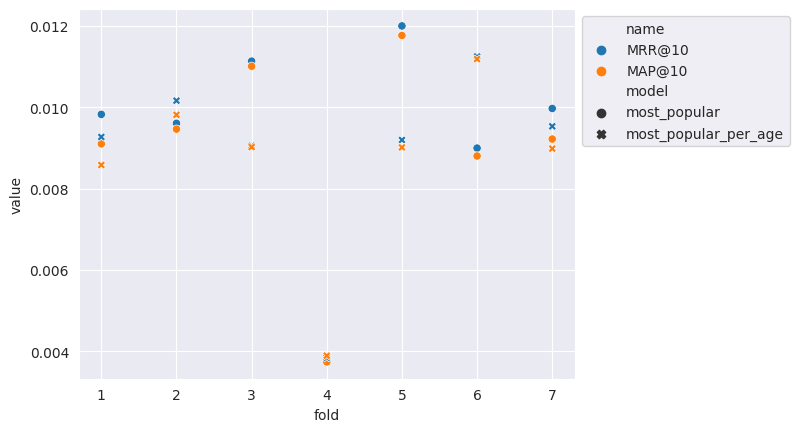

In [86]:
plot = sns.scatterplot(
    data=all_metrics.filter(pl.col("name").str.contains(r"(MAP@.+|MRR@.+)")), 
    x="fold", y="value", hue="name", style="model")
sns.move_legend(plot, loc="upper left", bbox_to_anchor=(1, 1))